In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import math
import copy

In [2]:
depthImage2 = copy.deepcopy(np.load("depth_image_3.npy"))
segImage2 = copy.deepcopy(np.load("seg_image_3.npy"))
regImage2 = copy.deepcopy(np.load("reg_image_3.npy"))

In [3]:
class Block():
    def __init__(self,name,pcd):
        self.blockPCD = pcd
        self.name = name
        # Removes outlier points by fitting block into largest cluster
        self.clusterBlockPCD()
        self.blockAABB = self.blockPCD.get_axis_aligned_bounding_box()
        self.robotCoordsDuringImage = np.array([-0.67743,-0.13328,-0.008594]) # the coordinates of the gripper when it took the images
        self.camCoords = self.getCameraCoordinates()
        self.robotCoords = self.getRobotCoordinates()
        
    def clusterBlockPCD(self):
        # modifies block PCD to only contain points in the largest cluster found with DBScan
        # eps found experimentally
        with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Error) as cm:
                # eps is radius
                # rejects points that are too small
                labels = np.array(self.blockPCD.cluster_dbscan(eps=0.013, min_points=20, print_progress=False))

        max_label = labels.max()
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        colors[labels < 0] = 0
        clusters = {}
        for i in range(0,max_label + 1):
            clusters[i] = []

        for i in range(0,len(labels)):
            if labels[i] != -1:
                clusters[labels[i]].append(i)

        clusterPCDs = []
        for clusterLabel in clusters:
            clusterPCD = self.blockPCD.select_by_index(clusters[clusterLabel])
            clusterPCDs.append(clusterPCD)
        self.blockPCD = clusterPCDs[0]
    
    def getCameraCoordinates(self):
        # returns the (x,y,z) coordinates in the camera's coordinates frame of where the gripper should be placed
        # center of front-facing axis-aligned bounding box
        x,y = self.blockAABB.get_center()[0:2]
        z = self.blockAABB.get_min_bound()[2]
        return (x,y,z)
    
    def getRobotCoordinates(self):
        xGripper,yGripper,zGripper = self.robotCoordsDuringImage
        xCam,yCam,zCam = self.camCoords
        #xGripper_Goal = xGripper - zCam
        #yGripper_Goal = yGripper + xCam
        #zGripper_Goal = zGripper - yCam
        # changed to deltas
        deltaXGripper = -zCam
        deltaYGripper = xCam
        deltaZGripper = -yCam
        return np.array([deltaXGripper,deltaYGripper,deltaZGripper])

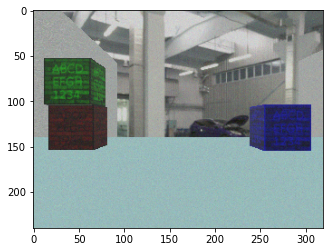

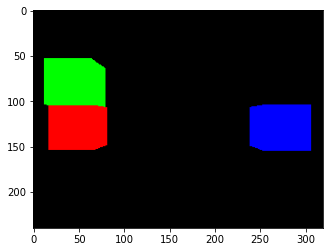

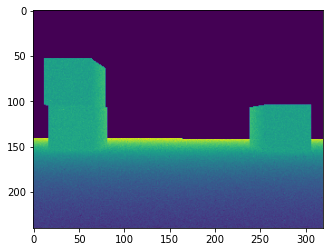

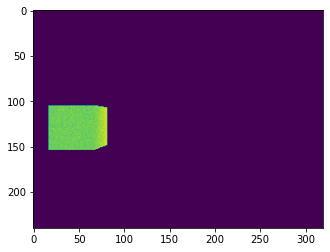

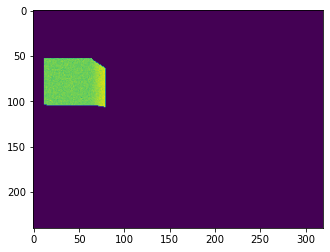

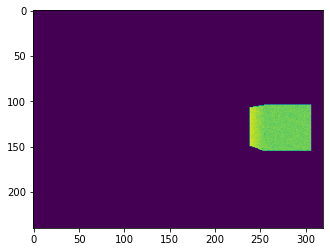

redBlock
dx: -0.578000009059906
dy: -0.22584999725222588
dz: -0.023787498474121094
redBlock
Cam Coordinates: (-0.22584999725222588, 0.023787498474121094, 0.578000009059906)
greenBlock
dx: -0.5569999814033508
dy: -0.22530468711629512
dz: 0.10589375421404838
greenBlock
Cam Coordinates: (-0.22530468711629512, -0.10589375421404838, 0.5569999814033508)
blueBlock
dx: -0.5550000071525574
dy: 0.22406874988228082
dz: -0.024333333720763527
blueBlock
Cam Coordinates: (0.22406874988228082, 0.024333333720763527, 0.5550000071525574)
FEngine (64 bits) created at 0x7fcaa1300000 (threading is enabled)
FEngine resolved backend: OpenGL


In [4]:
def showImages(images):
    for image in images:
        plt.imshow(image)
        plt.show()
    
def getBlocksFromImages(images):
    # takes in regular image, segmented image from webots, and depth image from range-finder
    regImage,segImage,depthImage = images
    # block pixels set to 255
    redMask = np.dot(segImage,[1,0,0,0]).astype('uint16') 
    redMask[redMask==255] = 1 # mask where red block has pixel value 1
    greenMask = np.dot(segImage,[0,1,0,0]).astype('uint16') 
    greenMask[greenMask==255] = 1
    blueMask = np.dot(segImage,[0,0,1,0]).astype('uint16') 
    blueMask[blueMask==255] = 1
    
    depthImage[depthImage==math.inf] = 0 # far away values set to 0 distance, =
    
    # mask the depth image using the monochromatic segmented image so that only blocks have defined values
    redDepthImage = np.multiply(depthImage,redMask)
    greenDepthImage = np.multiply(depthImage,greenMask)
    blueDepthImage = np.multiply(depthImage,blueMask)
    
    # depthImageSeg = np.multiply(depthImage,mask)
    images.append(redDepthImage)
    images.append(greenDepthImage)
    images.append(blueDepthImage)
    # SEGMENT PCD INTO RED,GREEN,BLUE BLOCKS
    redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(redDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)

    greenRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(greenDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)
    
    blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(blueDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)
    
    redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        redRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    greenPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        greenRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        blueRGBD_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    
    # flip point clouds since they start upside down
    # redPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # greenPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # bluePCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    redPCD.paint_uniform_color([1,0,0])
    greenPCD.paint_uniform_color([0,1,0])
    bluePCD.paint_uniform_color([0,0,1])
    redBlock = Block("redBlock",redPCD)
    greenBlock = Block("greenBlock",greenPCD)
    blueBlock = Block("blueBlock",bluePCD)
    
    showImages(images)
    return (redBlock,greenBlock,blueBlock)


def displayWorld(blocks):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    for block in blocks:
        geometry.append(block.blockPCD)
        geometry.append(block.blockAABB)
        blockCoordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05,origin=block.camCoords)
        geometry.append(blockCoordFrame)
        print(f"{block.name}")
        deltas = ["dx","dy","dz"]
        for i in range(0,len(block.robotCoords)):
            print(f"{deltas[i]}: {block.robotCoords[i]}")
            
        print(f"{block.name}\nCam Coordinates: {block.camCoords}")
        # print(f"Robot Coordinates: {block.robotCoords}")
    o3d.visualization.draw(geometry)

    
    
def getBlocks(images):
    blocks = getBlocksFromImages(images)
    redBlock,greenBlock,blueBlock = blocks
    return blocks




def getPredicates(blocks):
    # goal is to genreate a problem file, return which predicate holds for each block
    redBlock,greenBlock,blueBlock = blocks
    # hard-coded version would like to scale to arbitrary number of blocks
    predicates = []
    checkedPairs = set()
    for i in range(0,len(blocks)):
        blockA = blocks[i]
        blockA_coords = blockA.camCoords
        for j in range(0,len(blocks)):
            if i==j or ((i,j) in checkedPairs):
                continue
            blockB = blocks[j]
            blockA_coords = blockA.camCoords
            
            
           
            
            checkedPairs.add((i,j))
            
            
                
    
# goal is to go from images to PDDL Problem that can be solved in domain
# Need to look at predicates
def getWorldState(blocks):
    blocks = getBlocks(images)
    redBlock,greenBlock,blueBlock = blocks
    
    
blocks = getBlocks([regImage2,segImage2,depthImage2])
displayWorld(blocks)


In [2]:
# for each Block a return ON(Block a,Block b) or ON(Block table)
from py2pddl import parse


ModuleNotFoundError: No module named 'py2pddl'